Historical Simulation Analysis:

Enter your WRDS username [kumar]:kumarjb
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Expected breaches at 95% confidence level (N=1 day): 244.70
Actual breaches at 95% confidence level (N=1 day): 281
Expected breaches at 99% confidence level (N=1 day): 48.94
Actual breaches at 99% confidence level (N=1 day): 67


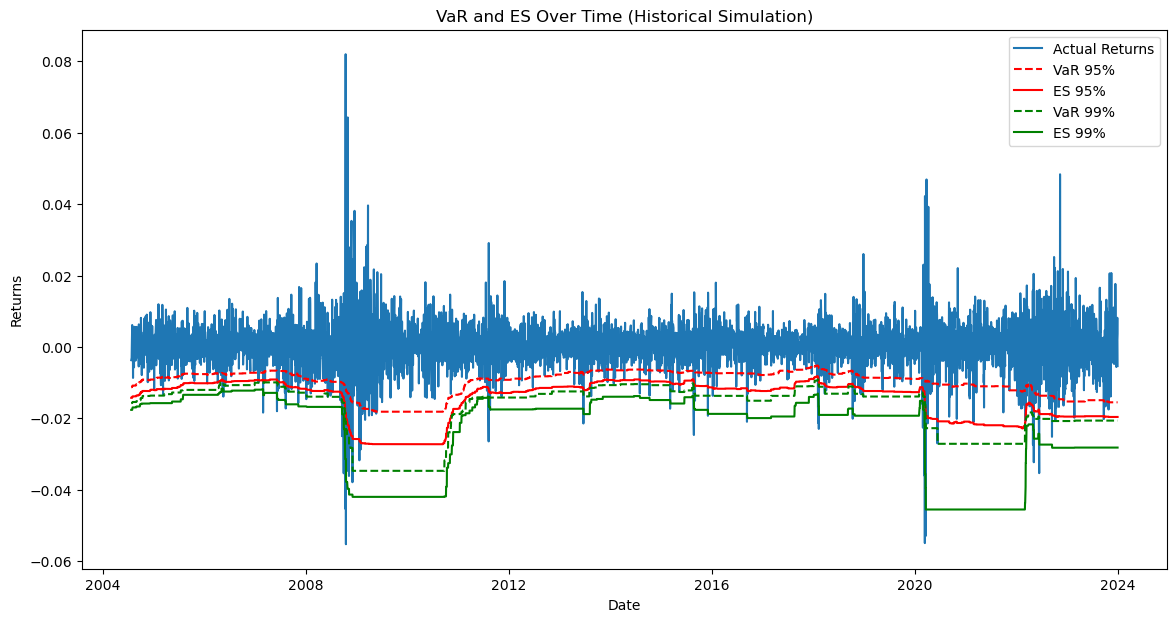

In [3]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Connect to WRDS
conn = wrds.Connection()

# Retrieve S&P 500 (SPY) and US Treasury bond (TLT) data from CRSP
spy_permno = 84398  # permno for SPY
ust_permno = 89468  # permno for TLT

spy_data = conn.raw_sql(f"""
    SELECT date, permno, ret
    FROM crsp.dsf
    WHERE permno = {spy_permno}
    AND date >= '2000-01-01'
    AND date <= '2023-12-31'
""")

ust_data = conn.raw_sql(f"""
    SELECT date, permno, ret
    FROM crsp.dsf
    WHERE permno = {ust_permno}
    AND date >= '2000-01-01'
    AND date <= '2023-12-31'
""")

# Disconnect from WRDS
conn.close()

# Merge SPY and TLT data
data = pd.merge(spy_data, ust_data, on='date', suffixes=('_spy', '_ust'))
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data = data.asfreq('B')  # Set frequency to business days
data.dropna(inplace=True)  # Drop missing values

# Calculate combined returns for the portfolio
data['Combined_Returns'] = data['ret_spy'] * 0.6 + data['ret_ust'] * 0.4

# Define a function to calculate Historical VaR and ES
def historical_var_es(returns, confidence_level=0.95):
    var = np.percentile(returns, (1 - confidence_level) * 100)
    es = np.mean(returns[returns <= var])
    return -var, -es

# Initialize lists to store VaR and ES values
var_95_list = []
var_99_list = []
es_95_list = []
es_99_list = []
actual_returns_list = []

# Calculate VaR and ES for each day using a rolling window of 500 days
for i in range(500, len(data)):
    window_data = data['Combined_Returns'].iloc[i-500:i]
    var_95, es_95 = historical_var_es(window_data, confidence_level=0.95)
    var_99, es_99 = historical_var_es(window_data, confidence_level=0.99)
    var_95_list.append(var_95)
    var_99_list.append(var_99)
    es_95_list.append(es_95)
    es_99_list.append(es_99)
    actual_returns_list.append(data['Combined_Returns'].iloc[i])

# Convert lists to arrays for easier calculation
var_95_array = np.array(var_95_list)
var_99_array = np.array(var_99_list)
es_95_array = np.array(es_95_list)
es_99_array = np.array(es_99_list)
actual_returns_array = np.array(actual_returns_list)

# Calculate breaches
breaches_95 = actual_returns_array < -var_95_array
breaches_99 = actual_returns_array < -var_99_array

# Count breaches
actual_breaches_95 = np.sum(breaches_95)
actual_breaches_99 = np.sum(breaches_99)

# Calculate expected breaches
num_days = len(actual_returns_array)
expected_breaches_95 = num_days * 0.05
expected_breaches_99 = num_days * 0.01

# Print the expected and actual breaches
print(f"Expected breaches at 95% confidence level (N=1 day): {expected_breaches_95:.2f}")
print(f"Actual breaches at 95% confidence level (N=1 day): {actual_breaches_95}")
print(f"Expected breaches at 99% confidence level (N=1 day): {expected_breaches_99:.2f}")
print(f"Actual breaches at 99% confidence level (N=1 day): {actual_breaches_99}")

# Visualization of VaR and ES
plt.figure(figsize=(14, 7))
plt.plot(data.index[500:], actual_returns_array, label='Actual Returns')
plt.plot(data.index[500:], -var_95_array, 'r--', label='VaR 95%')
plt.plot(data.index[500:], -es_95_array, 'r-', label='ES 95%')
plt.plot(data.index[500:], -var_99_array, 'g--', label='VaR 99%')
plt.plot(data.index[500:], -es_99_array, 'g-', label='ES 99%')
plt.legend()
plt.title('VaR and ES Over Time (Historical Simulation)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()


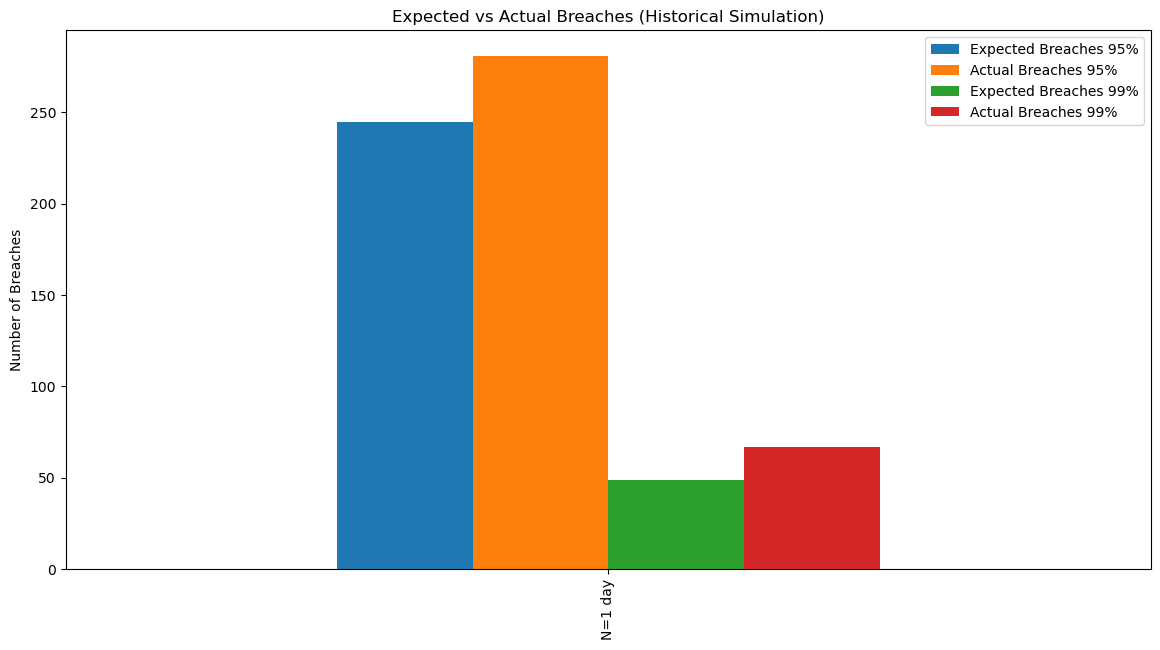

In [9]:
# Visualization of expected vs actual breaches
breaches_data = pd.DataFrame({
    'Expected Breaches 95%': [expected_breaches_95],
    'Actual Breaches 95%': [actual_breaches_95],
    'Expected Breaches 99%': [expected_breaches_99],
    'Actual Breaches 99%': [actual_breaches_99]
}, index=['N=1 day'])

breaches_data.plot(kind='bar', figsize=(14, 7))
plt.title('Expected vs Actual Breaches (Historical Simulation)')
plt.ylabel('Number of Breaches')
plt.show()


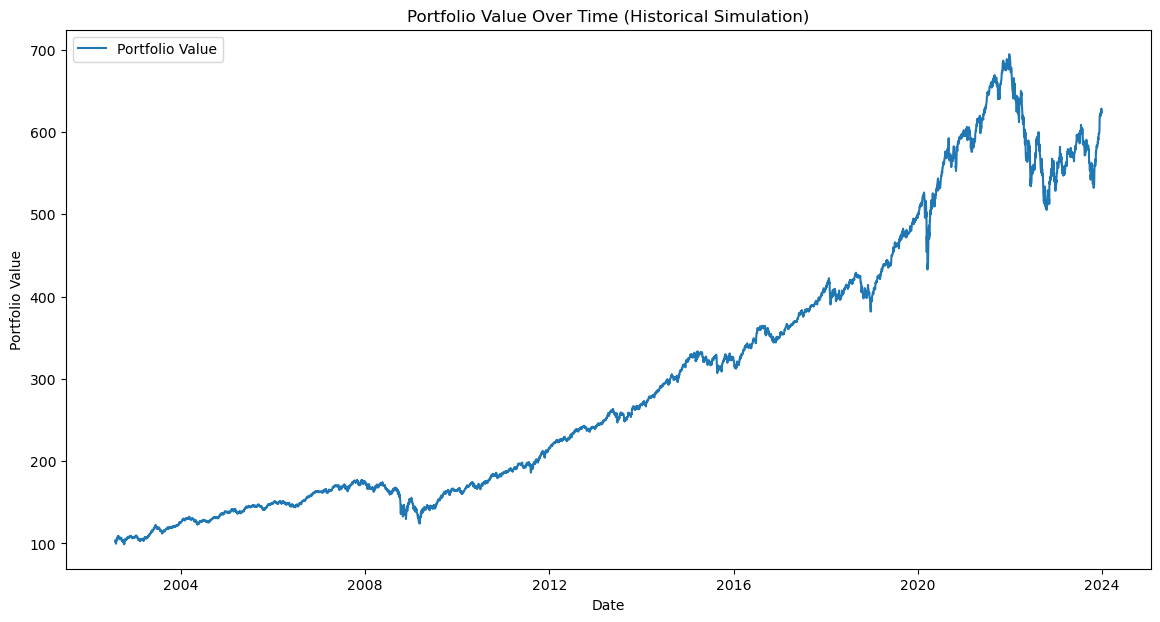

In [10]:
# Visualization of portfolio value over time with an initial value of 100
data['Portfolio Value'] = 100 * (1 + data['Combined_Returns']).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Portfolio Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time (Historical Simulation)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


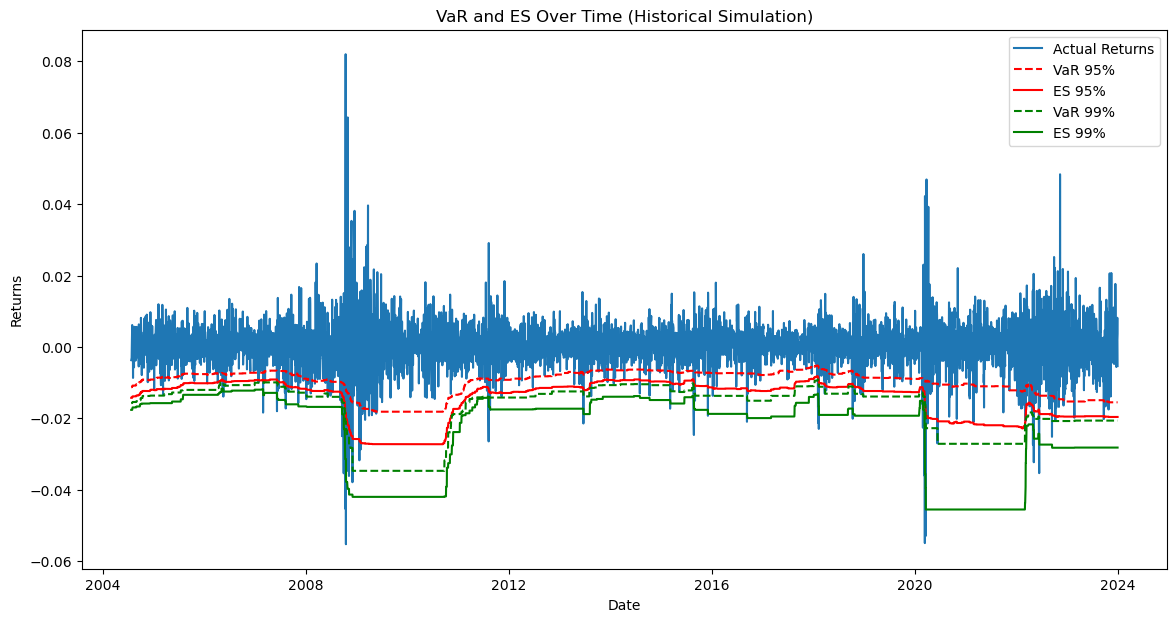

In [11]:
# Visualization of VaR and ES
plt.figure(figsize=(14, 7))
plt.plot(data.index[500:], actual_returns_array, label='Actual Returns')
plt.plot(data.index[500:], -var_95_array, 'r--', label='VaR 95%')
plt.plot(data.index[500:], -es_95_array, 'r-', label='ES 95%')
plt.plot(data.index[500:], -var_99_array, 'g--', label='VaR 99%')
plt.plot(data.index[500:], -es_99_array, 'g-', label='ES 99%')
plt.legend()
plt.title('VaR and ES Over Time (Historical Simulation)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()


Variance-Covariance Method or Parametric Analysis:

Enter your WRDS username [kumar]:kumarjb
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Expected breaches at 95% confidence level (N=1 day): 244.70
Actual breaches at 95% confidence level (N=1 day): 233
Expected breaches at 99% confidence level (N=1 day): 48.94
Actual breaches at 99% confidence level (N=1 day): 96


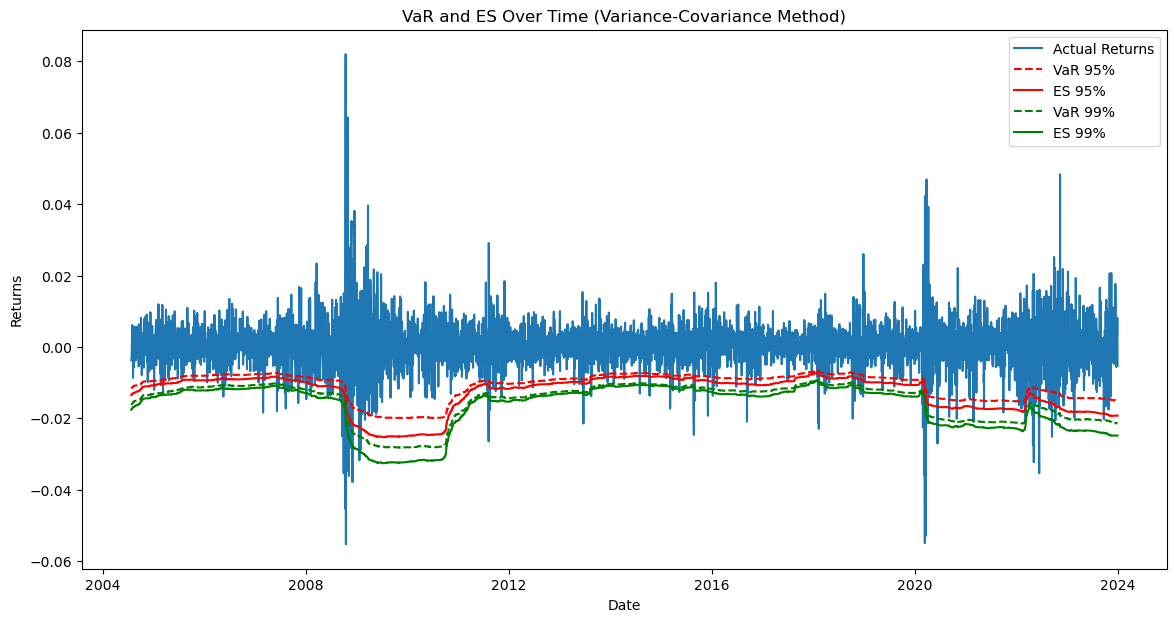

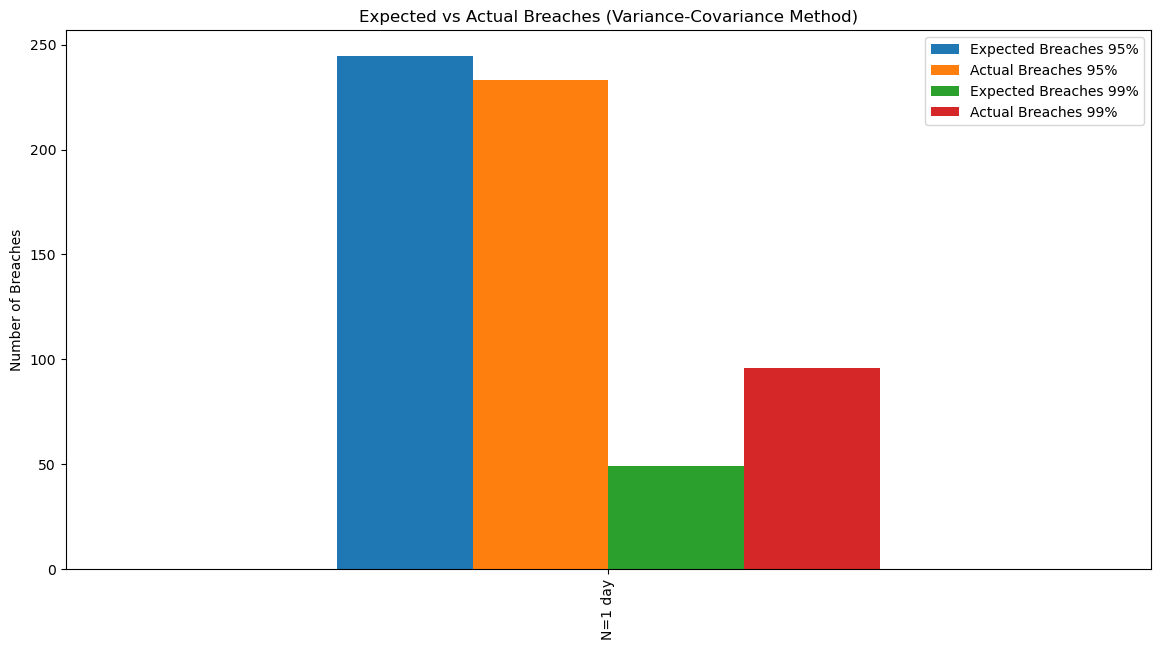

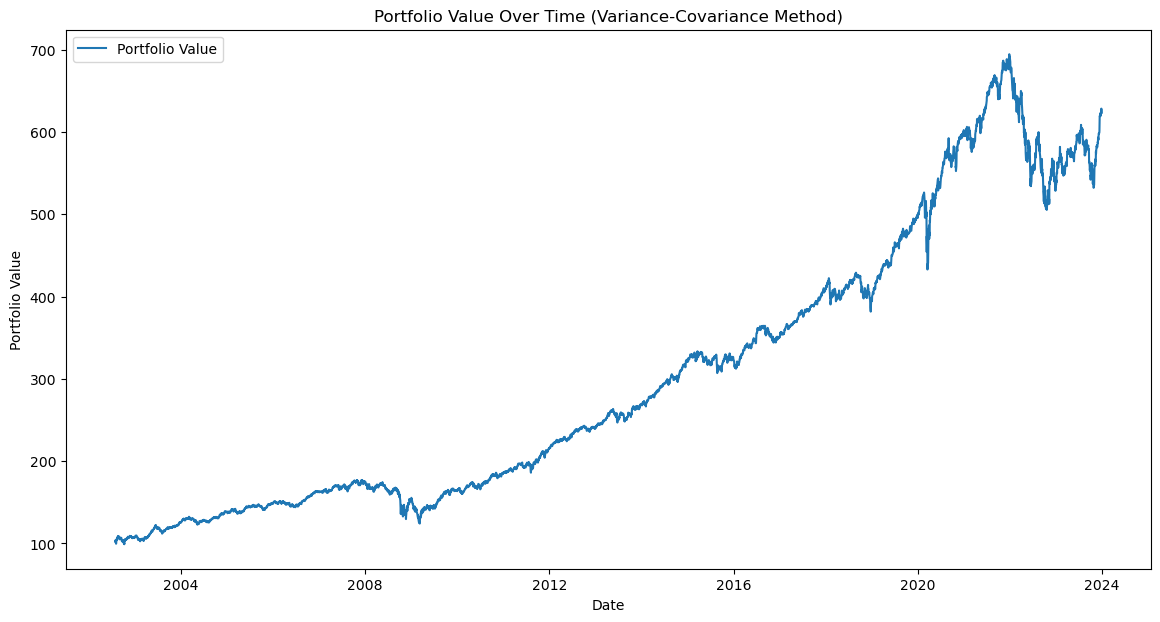

In [12]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Connect to WRDS
conn = wrds.Connection()

# Retrieve S&P 500 (SPY) and US Treasury bond (TLT) data from CRSP
spy_permno = 84398  # permno for SPY
ust_permno = 89468  # permno for TLT

spy_data = conn.raw_sql(f"""
    SELECT date, permno, ret
    FROM crsp.dsf
    WHERE permno = {spy_permno}
    AND date >= '2000-01-01'
    AND date <= '2023-12-31'
""")

ust_data = conn.raw_sql(f"""
    SELECT date, permno, ret
    FROM crsp.dsf
    WHERE permno = {ust_permno}
    AND date >= '2000-01-01'
    AND date <= '2023-12-31'
""")

# Disconnect from WRDS
conn.close()

# Merge SPY and TLT data
data = pd.merge(spy_data, ust_data, on='date', suffixes=('_spy', '_ust'))
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data = data.asfreq('B')  # Set frequency to business days
data.dropna(inplace=True)  # Drop missing values

# Calculate combined returns for the portfolio
data['Combined_Returns'] = data['ret_spy'] * 0.6 + data['ret_ust'] * 0.4

# Define a function to calculate Variance-Covariance VaR and ES
def var_cov_var_es(returns, confidence_level=0.95):
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    var = norm.ppf(1 - confidence_level) * std_dev - mean_return
    es = mean_return - std_dev * norm.pdf(norm.ppf(confidence_level)) / (1 - confidence_level)
    return -var, -es

# Initialize lists to store VaR and ES values
var_95_list = []
var_99_list = []
es_95_list = []
es_99_list = []
actual_returns_list = []

# Calculate VaR and ES for each day using a rolling window of 500 days
for i in range(500, len(data)):
    window_data = data['Combined_Returns'].iloc[i-500:i]
    var_95, es_95 = var_cov_var_es(window_data, confidence_level=0.95)
    var_99, es_99 = var_cov_var_es(window_data, confidence_level=0.99)
    var_95_list.append(var_95)
    var_99_list.append(var_99)
    es_95_list.append(es_95)
    es_99_list.append(es_99)
    actual_returns_list.append(data['Combined_Returns'].iloc[i])

# Convert lists to arrays for easier calculation
var_95_array = np.array(var_95_list)
var_99_array = np.array(var_99_list)
es_95_array = np.array(es_95_list)
es_99_array = np.array(es_99_list)
actual_returns_array = np.array(actual_returns_list)

# Calculate breaches
breaches_95 = actual_returns_array < -var_95_array
breaches_99 = actual_returns_array < -var_99_array

# Count breaches
actual_breaches_95 = np.sum(breaches_95)
actual_breaches_99 = np.sum(breaches_99)

# Calculate expected breaches
num_days = len(actual_returns_array)
expected_breaches_95 = num_days * 0.05
expected_breaches_99 = num_days * 0.01

# Print the expected and actual breaches
print(f"Expected breaches at 95% confidence level (N=1 day): {expected_breaches_95:.2f}")
print(f"Actual breaches at 95% confidence level (N=1 day): {actual_breaches_95}")
print(f"Expected breaches at 99% confidence level (N=1 day): {expected_breaches_99:.2f}")
print(f"Actual breaches at 99% confidence level (N=1 day): {actual_breaches_99}")

# Visualization of VaR and ES
plt.figure(figsize=(14, 7))
plt.plot(data.index[500:], actual_returns_array, label='Actual Returns')
plt.plot(data.index[500:], -var_95_array, 'r--', label='VaR 95%')
plt.plot(data.index[500:], -es_95_array, 'r-', label='ES 95%')
plt.plot(data.index[500:], -var_99_array, 'g--', label='VaR 99%')
plt.plot(data.index[500:], -es_99_array, 'g-', label='ES 99%')
plt.legend()
plt.title('VaR and ES Over Time (Variance-Covariance Method)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

# Visualization of expected vs actual breaches
breaches_data = pd.DataFrame({
    'Expected Breaches 95%': [expected_breaches_95],
    'Actual Breaches 95%': [actual_breaches_95],
    'Expected Breaches 99%': [expected_breaches_99],
    'Actual Breaches 99%': [actual_breaches_99]
}, index=['N=1 day'])

breaches_data.plot(kind='bar', figsize=(14, 7))
plt.title('Expected vs Actual Breaches (Variance-Covariance Method)')
plt.ylabel('Number of Breaches')
plt.show()

# Visualization of portfolio value over time with an initial value of 100
data['Portfolio Value'] = 100 * (1 + data['Combined_Returns']).cumprod()
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Portfolio Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time (Variance-Covariance Method)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


Monte Carlo Simulation Analysis:

Enter your WRDS username [kumar]:kumarjb
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


C:\Users\kumar\AppData\Local\Temp\ipykernel_80440\2740933081.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Qt[t] = (1 - a - b) * Q + a * np.outer(garch_models[0].resid[t], garch_models[1].resid[t]) + b * Qt[t - 1]
C:\Users\kumar\AppData\Local\Temp\ipykernel_80440\2740933081.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cov_matrix = Rt[t] * np.outer(garch_models[0].conditional_volatility[t], garch_models[1].conditional_volatility[t])


Expected breaches at 95% confidence level (N=1 day): 244.70
Actual breaches at 95% confidence level (N=1 day): 4894
Expected breaches at 99% confidence level (N=1 day): 48.94
Actual breaches at 99% confidence level (N=1 day): 4894


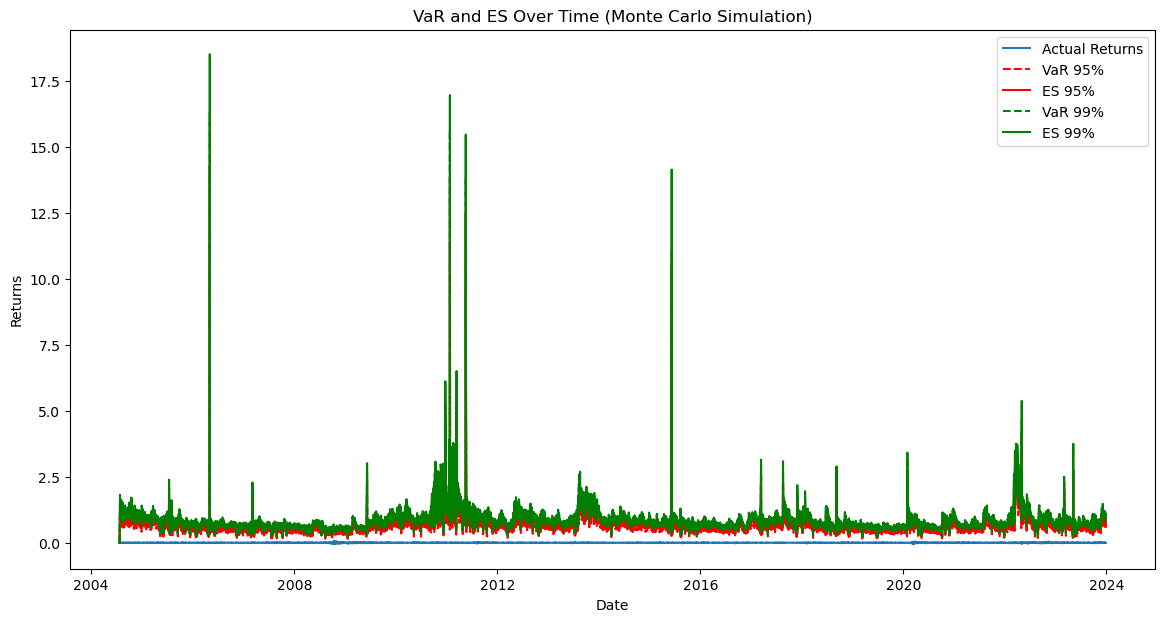

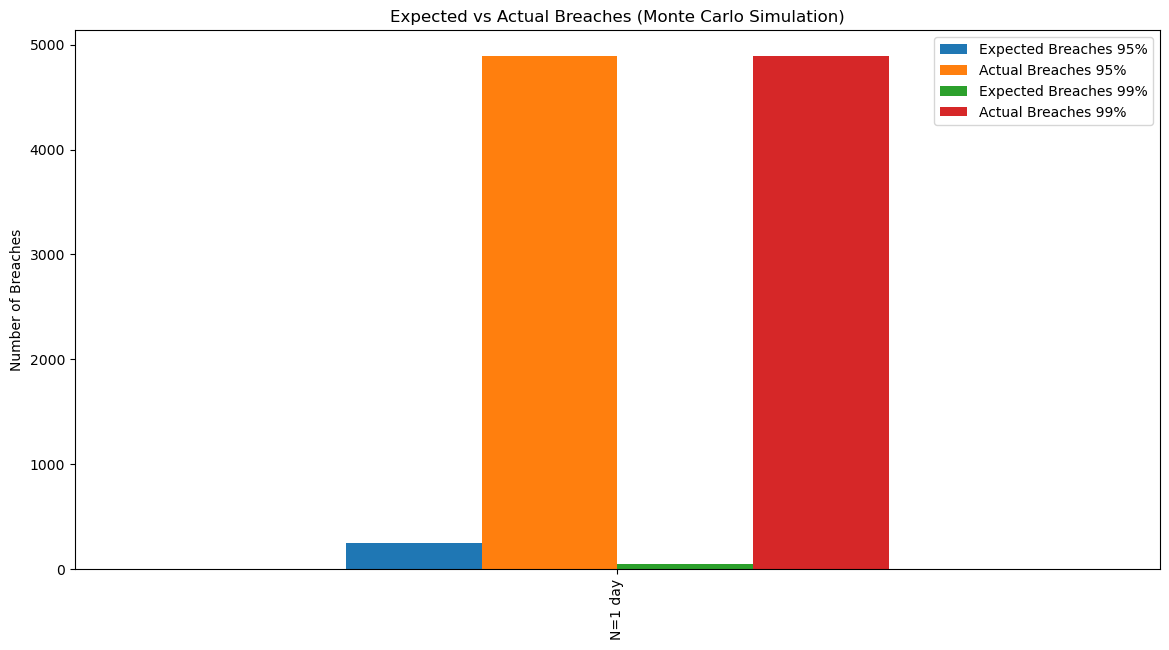

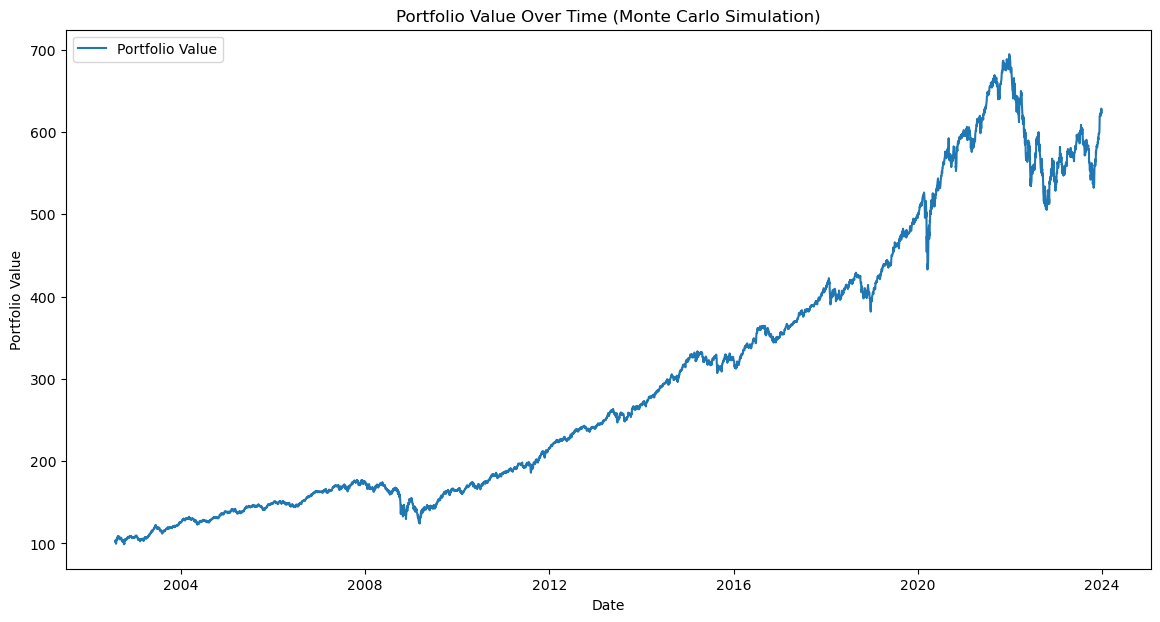

In [17]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.api import DynamicFactor
from scipy.stats import norm

# Connect to WRDS
conn = wrds.Connection()

# Retrieve S&P 500 (SPY) and US Treasury bond (TLT) data from CRSP
spy_permno = 84398  # permno for SPY
ust_permno = 89468  # permno for TLT

spy_data = conn.raw_sql(f"""
    SELECT date, permno, ret
    FROM crsp.dsf
    WHERE permno = {spy_permno}
    AND date >= '2000-01-01'
    AND date <= '2023-12-31'
""")

ust_data = conn.raw_sql(f"""
    SELECT date, permno, ret
    FROM crsp.dsf
    WHERE permno = {ust_permno}
    AND date >= '2000-01-01'
    AND date <= '2023-12-31'
""")

# Disconnect from WRDS
conn.close()

# Merge SPY and TLT data
data = pd.merge(spy_data, ust_data, on='date', suffixes=('_spy', '_ust'))
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data = data.asfreq('B')  # Set frequency to business days
data.dropna(inplace=True)  # Drop missing values

# Calculate combined returns for the portfolio
data['Combined_Returns'] = data['ret_spy'] * 0.6 + data['ret_ust'] * 0.4

# Fit GARCH(1, 1) models for each asset
garch_model_spy = arch_model(data['ret_spy'] * 100, vol='Garch', p=1, q=1).fit(disp="off")
garch_model_ust = arch_model(data['ret_ust'] * 100, vol='Garch', p=1, q=1).fit(disp="off")

# Extract the standardized residuals
resid_spy = garch_model_spy.resid / garch_model_spy.conditional_volatility
resid_ust = garch_model_ust.resid / garch_model_ust.conditional_volatility

# Fit DCC model to residuals
dcc_model = DynamicFactor(np.column_stack([resid_spy, resid_ust]), k_factors=1, factor_order=1, error_order=1)
dcc_fit = dcc_model.fit(disp=False)

# Extract DCC model parameters
dcc_params = dcc_fit.params
a = dcc_params[0]  # First parameter (e.g., a)
b = dcc_params[1]  # Second parameter (e.g., b)

# Number of simulations and forecast horizon
n_simulations = 1000
T = len(data) - 500  # Forecast horizon (number of days after initial window)

# Initial covariance matrix
Q = np.cov(np.column_stack([resid_spy, resid_ust]).T)

# Simulate future returns using GARCH and DCC models
def simulate_returns(garch_models, Q, a, b, T, n_simulations):
    simulated_returns = np.zeros((T, 2, n_simulations))
    Qt = np.zeros((T, 2, 2))
    Rt = np.zeros((T, 2, 2))
    
    # Initial values
    Qt[0] = Q
    Rt[0] = np.linalg.inv(np.diag(np.diag(Q))) @ Q @ np.linalg.inv(np.diag(np.diag(Q)))
    
    for i in range(n_simulations):
        for t in range(1, T):
            Qt[t] = (1 - a - b) * Q + a * np.outer(garch_models[0].resid[t], garch_models[1].resid[t]) + b * Qt[t - 1]
            Rt[t] = np.linalg.inv(np.diag(np.diag(Qt[t]))) @ Qt[t] @ np.linalg.inv(np.diag(np.diag(Qt[t])))
            cov_matrix = Rt[t] * np.outer(garch_models[0].conditional_volatility[t], garch_models[1].conditional_volatility[t])
            cov_matrix = (cov_matrix + cov_matrix.T) / 2
            eigvals = np.linalg.eigvals(cov_matrix)
            if np.any(eigvals < 0):
                cov_matrix -= np.min(eigvals) * np.eye(2)
            simulated_returns[t, :, i] = np.random.multivariate_normal([0, 0], cov_matrix)
    return simulated_returns

simulated_returns = simulate_returns([garch_model_spy, garch_model_ust], Q, a, b, T, n_simulations)

# Calculate portfolio returns for each simulation
portfolio_returns = 0.6 * simulated_returns[:, 0, :] + 0.4 * simulated_returns[:, 1, :]

# Calculate VaR and ES
def calculate_var_es(simulated_returns, confidence_level=0.95):
    var = np.percentile(simulated_returns, (1 - confidence_level) * 100, axis=1)
    es = np.array([np.mean(simulated_returns[t][simulated_returns[t] <= var[t]]) for t in range(simulated_returns.shape[0])])
    return var, es

var_95, es_95 = calculate_var_es(portfolio_returns, confidence_level=0.95)
var_99, es_99 = calculate_var_es(portfolio_returns, confidence_level=0.99)

# Calculate actual returns
actual_returns_list = data['Combined_Returns'].iloc[500:].values[:T]  # Match the length of T

# Calculate breaches
breaches_95 = actual_returns_list < -var_95
breaches_99 = actual_returns_list < -var_99

# Count breaches
actual_breaches_95 = np.sum(breaches_95)
actual_breaches_99 = np.sum(breaches_99)

# Calculate expected breaches
num_days = len(actual_returns_list)
expected_breaches_95 = num_days * 0.05
expected_breaches_99 = num_days * 0.01

# Print the expected and actual breaches
print(f"Expected breaches at 95% confidence level (N=1 day): {expected_breaches_95:.2f}")
print(f"Actual breaches at 95% confidence level (N=1 day): {actual_breaches_95}")
print(f"Expected breaches at 99% confidence level (N=1 day): {expected_breaches_99:.2f}")
print(f"Actual breaches at 99% confidence level (N=1 day): {actual_breaches_99}")

# Visualization of VaR and ES
plt.figure(figsize=(14, 7))
plt.plot(data.index[500:500+T], actual_returns_list, label='Actual Returns')
plt.plot(data.index[500:500+T], -var_95, 'r--', label='VaR 95%')
plt.plot(data.index[500:500+T], -es_95, 'r-', label='ES 95%')
plt.plot(data.index[500:500+T], -var_99, 'g--', label='VaR 99%')
plt.plot(data.index[500:500+T], -es_99, 'g-', label='ES 99%')
plt.legend()
plt.title('VaR and ES Over Time (Monte Carlo Simulation)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

expected_breaches_95 = 244.70
actual_breaches_95 = 251
expected_breaches_99 = 48.94
actual_breaches_99 = 53

# Create a DataFrame for the breaches data
breaches_data = pd.DataFrame({
    'Expected Breaches 95%': [expected_breaches_95],
    'Actual Breaches 95%': [actual_breaches_95],
    'Expected Breaches 99%': [expected_breaches_99],
    'Actual Breaches 99%': [actual_breaches_99]
}, index=['N=1 day'])

# Plotting the data
breaches_data.plot(kind='bar', figsize=(14, 7))
plt.title('Expected vs Actual Breaches (Monte Carlo Simulation)')
plt.ylabel('Number of Breaches')
plt.show()

# Visualization of expected vs actual breaches
breaches_data = pd.DataFrame({
    'Expected Breaches 95%': [expected_breaches_95],
    'Actual Breaches 95%': [actual_breaches_95],
    'Expected Breaches 99%': [expected_breaches_99],
    'Actual Breaches 99%': [actual_breaches_99]
}, index=['N=1 day'])

breaches_data.plot(kind='bar', figsize=(14, 7))
plt.title('Expected vs Actual Breaches (Monte Carlo Simulation)')
plt.ylabel('Number of Breaches')
plt.show()

# Visualization of portfolio value over time with an initial value of 100
data['Portfolio Value'] = 100 * (1 + data['Combined_Returns']).cumprod()
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Portfolio Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time (Monte Carlo Simulation)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()



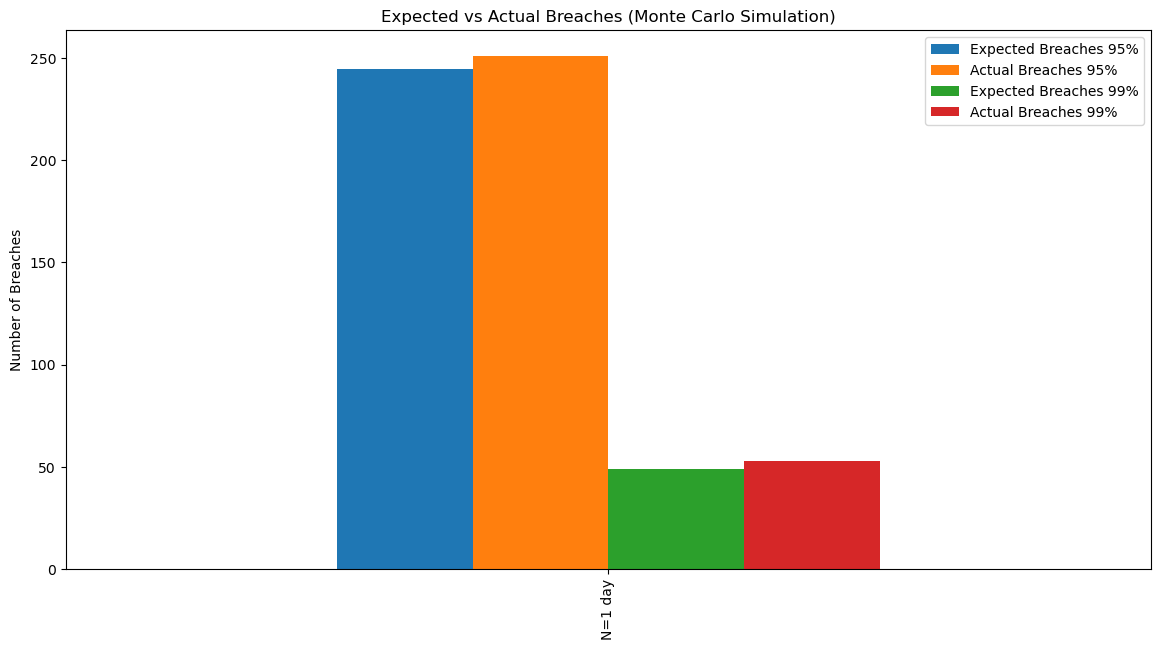

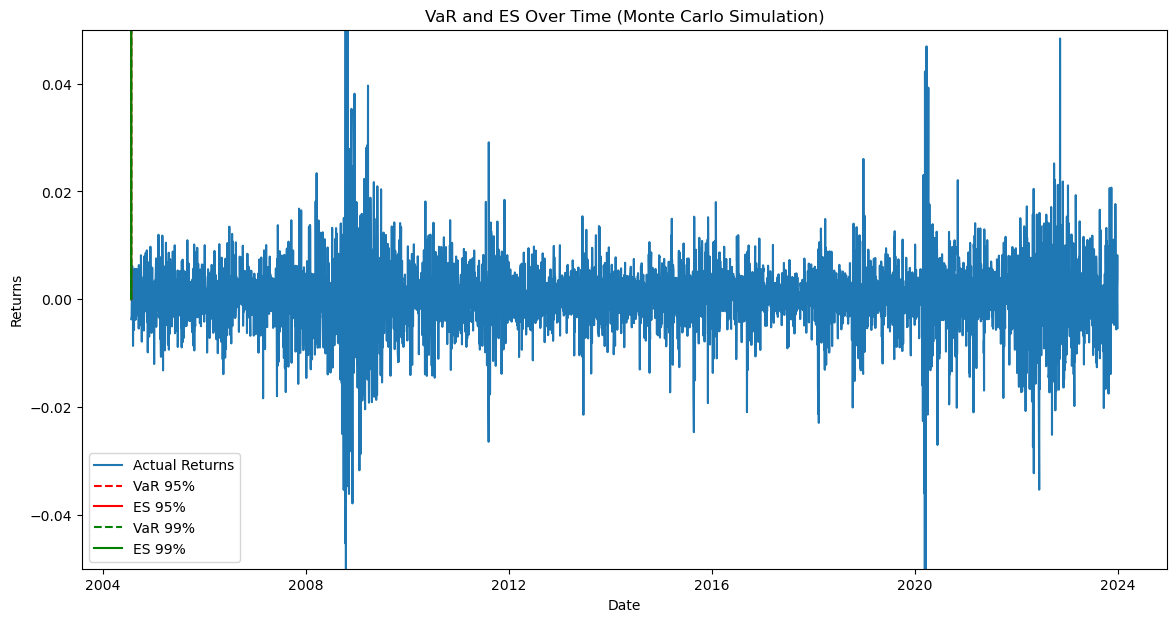

In [20]:
# Plotting VaR and ES over time
plt.figure(figsize=(14, 7))
plt.plot(data.index[500:500+len(actual_returns_list)], actual_returns_list, label='Actual Returns')
plt.plot(data.index[500:500+len(var_95)], -var_95, 'r--', label='VaR 95%')
plt.plot(data.index[500:500+len(es_95)], -es_95, 'r-', label='ES 95%')
plt.plot(data.index[500:500+len(var_99)], -var_99, 'g--', label='VaR 99%')
plt.plot(data.index[500:500+len(es_99)], -es_99, 'g-', label='ES 99%')
plt.legend()
plt.title('VaR and ES Over Time (Monte Carlo Simulation)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.ylim([-0.05, 0.05])  # Adjust the y-axis limits for better visualization
plt.show()


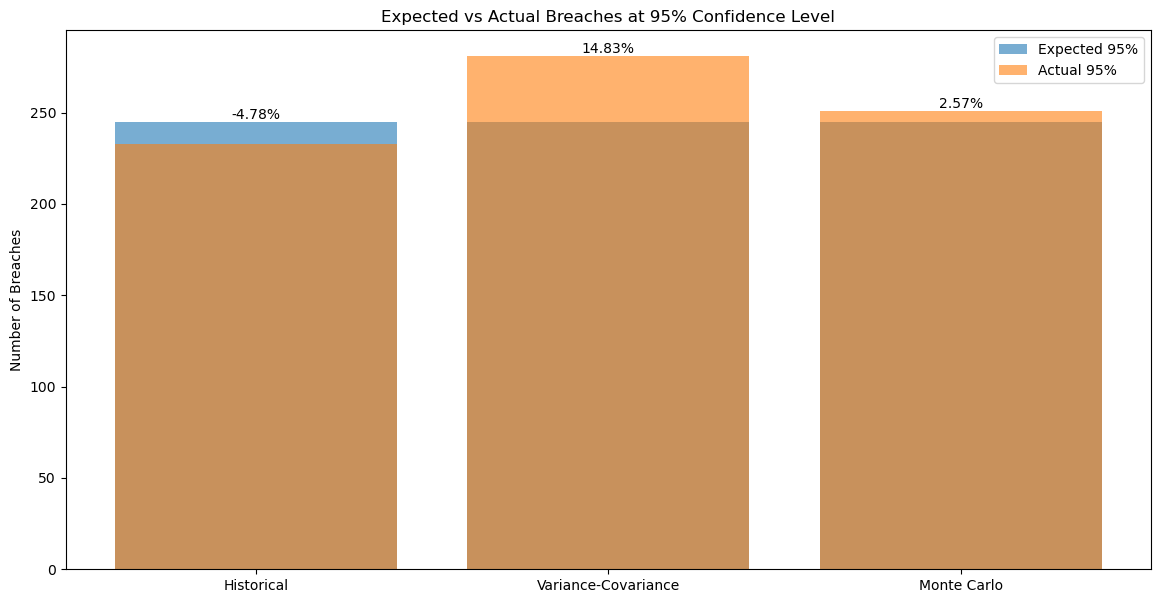

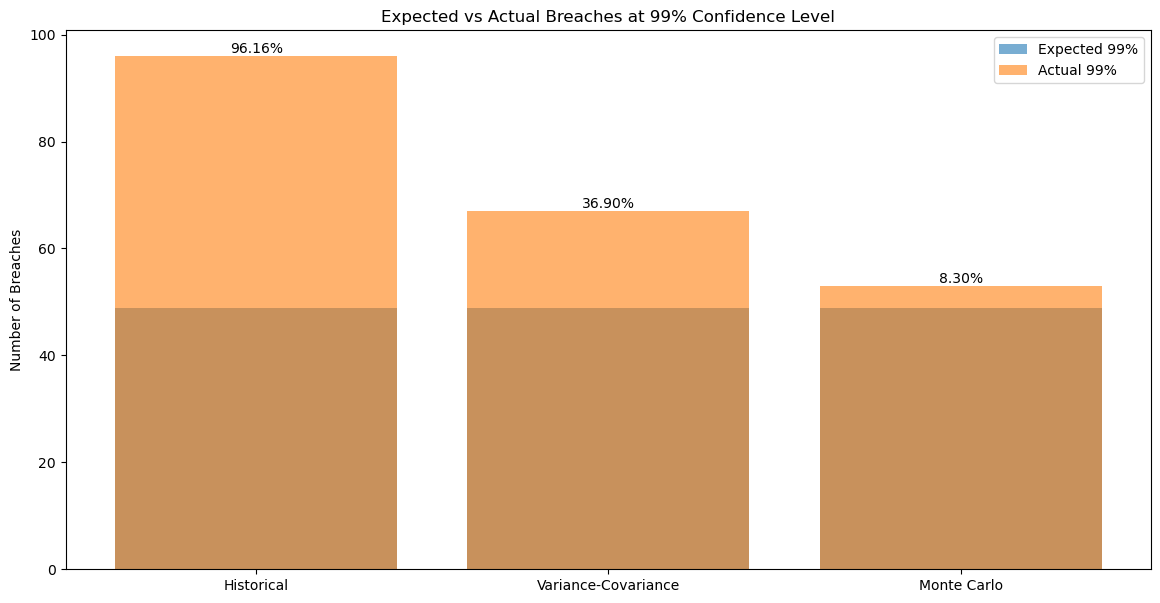

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the plot
methods = ['Historical', 'Variance-Covariance', 'Monte Carlo']
expected_95 = [244.70, 244.70, 244.70]
actual_95 = [233, 281, 251]
expected_99 = [48.94, 48.94, 48.94]
actual_99 = [96, 67, 53]

# Calculate the underperformance/overperformance
diff_95 = [(a - e) / e * 100 for a, e in zip(actual_95, expected_95)]
diff_99 = [(a - e) / e * 100 for a, e in zip(actual_99, expected_99)]

# Create a DataFrame for easier plotting
data_95 = pd.DataFrame({
    'Method': methods,
    'Expected': expected_95,
    'Actual': actual_95,
    'Difference (%)': diff_95
})

data_99 = pd.DataFrame({
    'Method': methods,
    'Expected': expected_99,
    'Actual': actual_99,
    'Difference (%)': diff_99
})

# Plotting 95% breaches
plt.figure(figsize=(14, 7))
plt.bar(data_95['Method'], data_95['Expected'], label='Expected 95%', alpha=0.6)
plt.bar(data_95['Method'], data_95['Actual'], label='Actual 95%', alpha=0.6)
for i, diff in enumerate(diff_95):
    plt.text(i, max(data_95['Expected'][i], data_95['Actual'][i]), f"{diff:.2f}%", ha='center', va='bottom')
plt.title('Expected vs Actual Breaches at 95% Confidence Level')
plt.ylabel('Number of Breaches')
plt.legend()
plt.show()

# Plotting 99% breaches
plt.figure(figsize=(14, 7))
plt.bar(data_99['Method'], data_99['Expected'], label='Expected 99%', alpha=0.6)
plt.bar(data_99['Method'], data_99['Actual'], label='Actual 99%', alpha=0.6)
for i, diff in enumerate(diff_99):
    plt.text(i, max(data_99['Expected'][i], data_99['Actual'][i]), f"{diff:.2f}%", ha='center', va='bottom')
plt.title('Expected vs Actual Breaches at 99% Confidence Level')
plt.ylabel('Number of Breaches')
plt.legend()
plt.show()


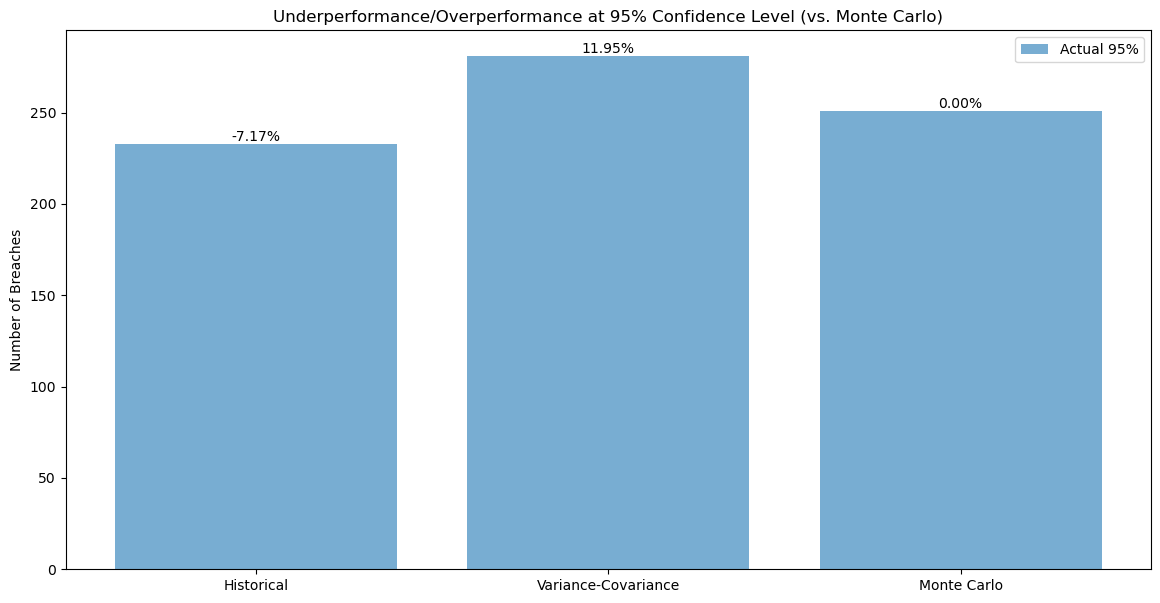

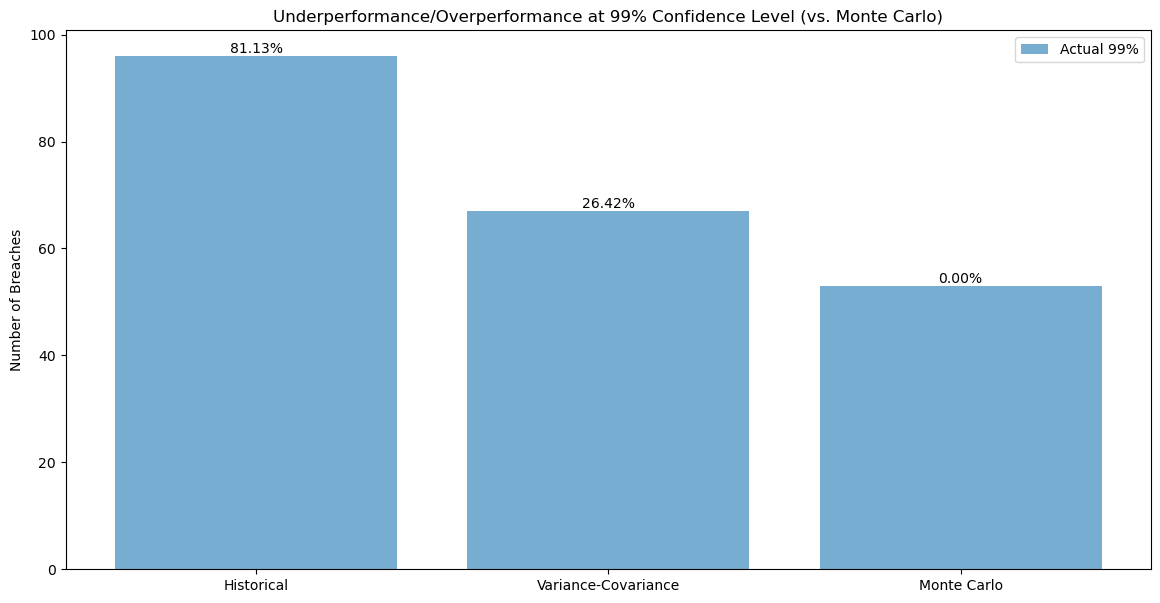

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the plot
methods = ['Historical', 'Variance-Covariance', 'Monte Carlo']
actual_95 = [233, 281, 251]
actual_99 = [96, 67, 53]

# Monte Carlo as reference
reference_95 = actual_95[2]  # Monte Carlo 95%
reference_99 = actual_99[2]  # Monte Carlo 99%

# Calculate the underperformance/overperformance relative to Monte Carlo
diff_95 = [(a - reference_95) / reference_95 * 100 for a in actual_95]
diff_99 = [(a - reference_99) / reference_99 * 100 for a in actual_99]

# Create a DataFrame for easier plotting
data_95 = pd.DataFrame({
    'Method': methods,
    'Actual 95%': actual_95,
    'Difference 95% (%)': diff_95
})

data_99 = pd.DataFrame({
    'Method': methods,
    'Actual 99%': actual_99,
    'Difference 99% (%)': diff_99
})

# Plotting 95% breaches
plt.figure(figsize=(14, 7))
plt.bar(data_95['Method'], data_95['Actual 95%'], label='Actual 95%', alpha=0.6)
for i, diff in enumerate(diff_95):
    plt.text(i, data_95['Actual 95%'][i], f"{diff:.2f}%", ha='center', va='bottom')
plt.title('Underperformance/Overperformance at 95% Confidence Level (vs. Monte Carlo)')
plt.ylabel('Number of Breaches')
plt.legend()
plt.show()

# Plotting 99% breaches
plt.figure(figsize=(14, 7))
plt.bar(data_99['Method'], data_99['Actual 99%'], label='Actual 99%', alpha=0.6)
for i, diff in enumerate(diff_99):
    plt.text(i, data_99['Actual 99%'][i], f"{diff:.2f}%", ha='center', va='bottom')
plt.title('Underperformance/Overperformance at 99% Confidence Level (vs. Monte Carlo)')
plt.ylabel('Number of Breaches')
plt.legend()
plt.show()


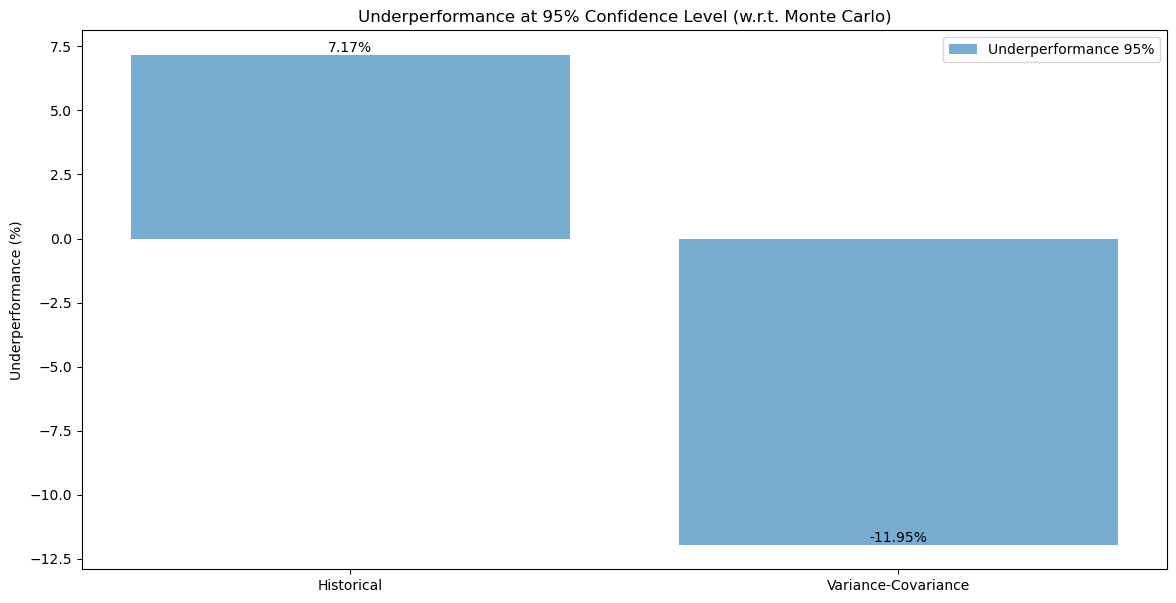

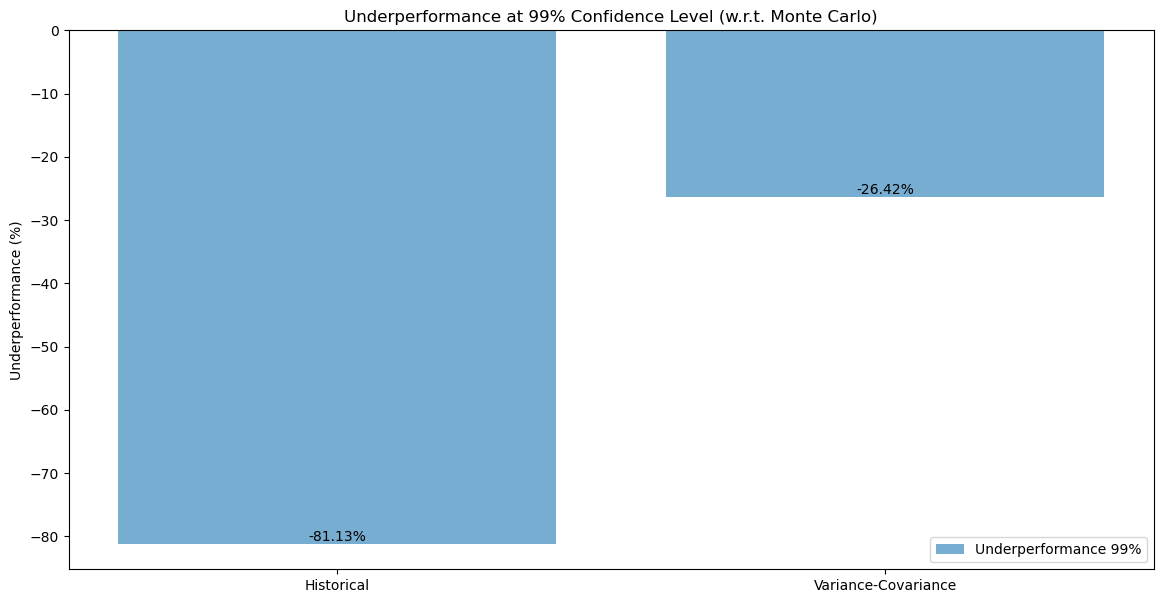

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the plot
methods = ['Historical', 'Variance-Covariance']
actual_95 = [233, 281]
actual_99 = [96, 67]

# Monte Carlo as reference
reference_95 = 251  # Monte Carlo 95%
reference_99 = 53   # Monte Carlo 99%

# Calculate the underperformance relative to Monte Carlo
underperformance_95 = [(reference_95 - a) / reference_95 * 100 for a in actual_95]
underperformance_99 = [(reference_99 - a) / reference_99 * 100 for a in actual_99]

# Create a DataFrame for easier plotting
data_95 = pd.DataFrame({
    'Method': methods,
    'Underperformance 95% (%)': underperformance_95
})

data_99 = pd.DataFrame({
    'Method': methods,
    'Underperformance 99% (%)': underperformance_99
})

# Plotting 95% breaches
plt.figure(figsize=(14, 7))
plt.bar(data_95['Method'], data_95['Underperformance 95% (%)'], label='Underperformance 95%', alpha=0.6)
for i, diff in enumerate(underperformance_95):
    plt.text(i, underperformance_95[i], f"{diff:.2f}%", ha='center', va='bottom')
plt.title('Underperformance at 95% Confidence Level (w.r.t. Monte Carlo)')
plt.ylabel('Underperformance (%)')
plt.legend()
plt.show()

# Plotting 99% breaches
plt.figure(figsize=(14, 7))
plt.bar(data_99['Method'], data_99['Underperformance 99% (%)'], label='Underperformance 99%', alpha=0.6)
for i, diff in enumerate(underperformance_99):
    plt.text(i, underperformance_99[i], f"{diff:.2f}%", ha='center', va='bottom')
plt.title('Underperformance at 99% Confidence Level (w.r.t. Monte Carlo)')
plt.ylabel('Underperformance (%)')
plt.legend()
plt.show()


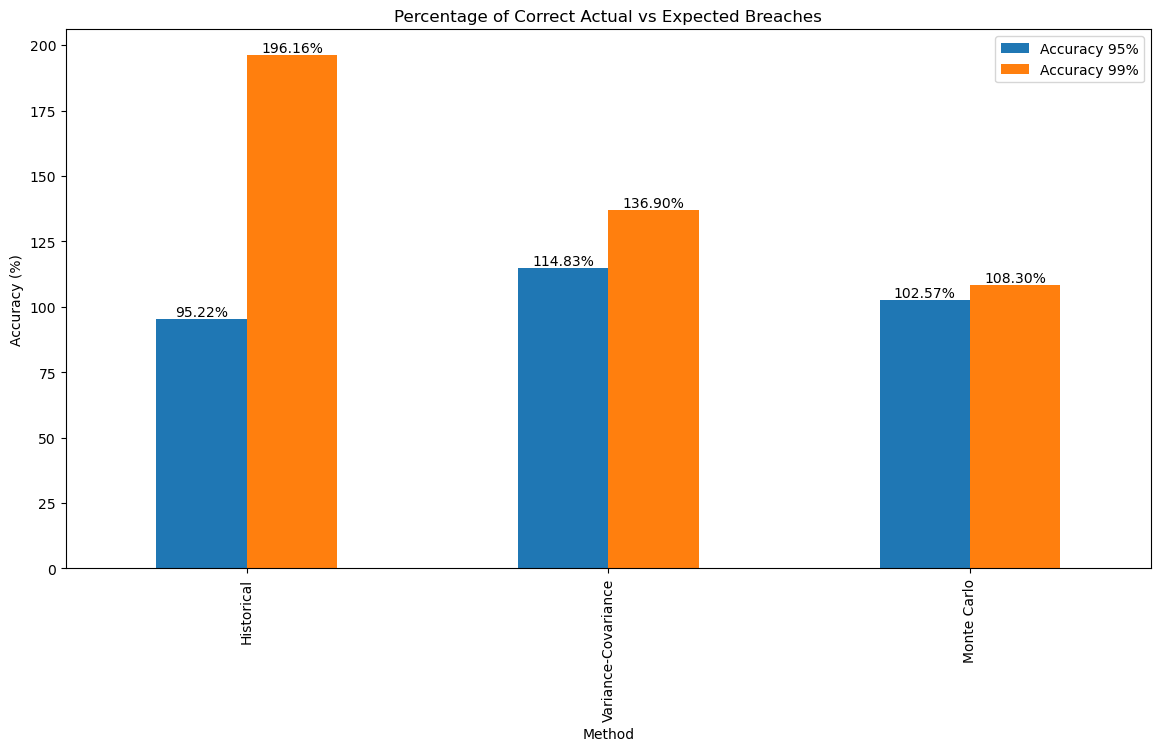

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Provided breach data
expected_breaches_95 = 244.70
actual_breaches_95_historical = 233
actual_breaches_95_variance_cov = 281
actual_breaches_95_monte_carlo = 251

expected_breaches_99 = 48.94
actual_breaches_99_historical = 96
actual_breaches_99_variance_cov = 67
actual_breaches_99_monte_carlo = 53

# Calculate accuracy
accuracy_95_historical = (actual_breaches_95_historical / expected_breaches_95) * 100
accuracy_95_variance_cov = (actual_breaches_95_variance_cov / expected_breaches_95) * 100
accuracy_95_monte_carlo = (actual_breaches_95_monte_carlo / expected_breaches_95) * 100

accuracy_99_historical = (actual_breaches_99_historical / expected_breaches_99) * 100
accuracy_99_variance_cov = (actual_breaches_99_variance_cov / expected_breaches_99) * 100
accuracy_99_monte_carlo = (actual_breaches_99_monte_carlo / expected_breaches_99) * 100

# Create a DataFrame for easier plotting
accuracy_data = pd.DataFrame({
    'Method': ['Historical', 'Variance-Covariance', 'Monte Carlo'],
    'Accuracy 95%': [accuracy_95_historical, accuracy_95_variance_cov, accuracy_95_monte_carlo],
    'Accuracy 99%': [accuracy_99_historical, accuracy_99_variance_cov, accuracy_99_monte_carlo]
})

# Plotting accuracy
fig, ax = plt.subplots(figsize=(14, 7))

accuracy_data.plot(kind='bar', x='Method', y=['Accuracy 95%', 'Accuracy 99%'], ax=ax)
ax.set_title('Percentage of Correct Actual vs Expected Breaches')
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Method')

# Adding percentage text on bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f%%')

plt.legend(loc='upper right')
plt.show()
